In [1]:
import numpy as np
import tqdm
from PIL import Image
import torch
from IPython import display
from facedetector import FaceDetector
from dataloaders.transforms import transform
from dataloaders.WIDERloader import WIDERLoader
from models.VanillaClassificator import MaskDetectionModel
from models.MultiLabelClassificator import MultilabelClassificator, multilabel_classificator_v2
from facenet_pytorch import MTCNN
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import tqdm
from PIL import Image, ImageFont
import torch
from IPython import display
from facedetector import FaceDetector
from dataloaders.WIDERloader import WIDERLoader
from dataloaders.transforms import transform
from dataloaders.MAFAloader import MAFALoader, collate_fn
from models.VanillaClassificator import MaskDetectionModel
from models.MultiLabelClassificator import MultilabelClassificator
from models import FAN_detector
from models.Custom_model import make_model, Flatten, vgg_classif
from metrics import mAP, multilabel_mAP
from facenet_pytorch import MTCNN
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from torch.utils.data.dataset import Dataset
import os
import scipy
import scipy.io
import pandas as pd
import tensorboard
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

In [3]:
device = ('cuda' if torch.cuda.is_available else 'cpu')

In [4]:
detector = FAN_detector.resnet34(num_classes=3)
detector.load_state_dict(torch.load('./weights/FAN.best.pth'))
detector.eval()
detector.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
checkpoint = torch.load('./weights/custom_epoch17.pth')
classif = make_model()
classif.load_state_dict(checkpoint['state_dict'])
classif.eval()
classif.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU()
  (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU()
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): BatchNorm2d(256, eps=1e-05, momen

In [6]:
# classif = vgg_classif()
# classif.classifier = torch.load('./weights/vgg11_bn.best.pth')
# classif.cuda()

## Images

### MTCNN

In [7]:
detector = MTCNN(keep_all=True, device=device)
face_detector = FaceDetector(classif, detector, detector_type='mtcnn')

In [8]:
img = Image.open('./imgs/test_img.png')
imd_draw, faces,_ = face_detector.process_image(img, put_text=False)

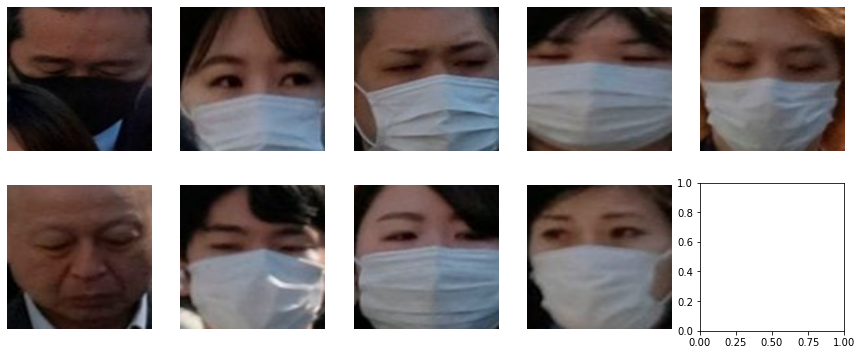

In [9]:
n_row = 2
n_col = len(faces)//2 + 1
_, axs = plt.subplots(n_row, n_col, figsize=(int(6*n_col/n_row), 6))
axs = axs.flatten()
for face, ax in zip(faces, axs):
    ax.imshow(TF.to_pil_image(face), aspect = 'equal')
    ax.axis('off')
plt.show()

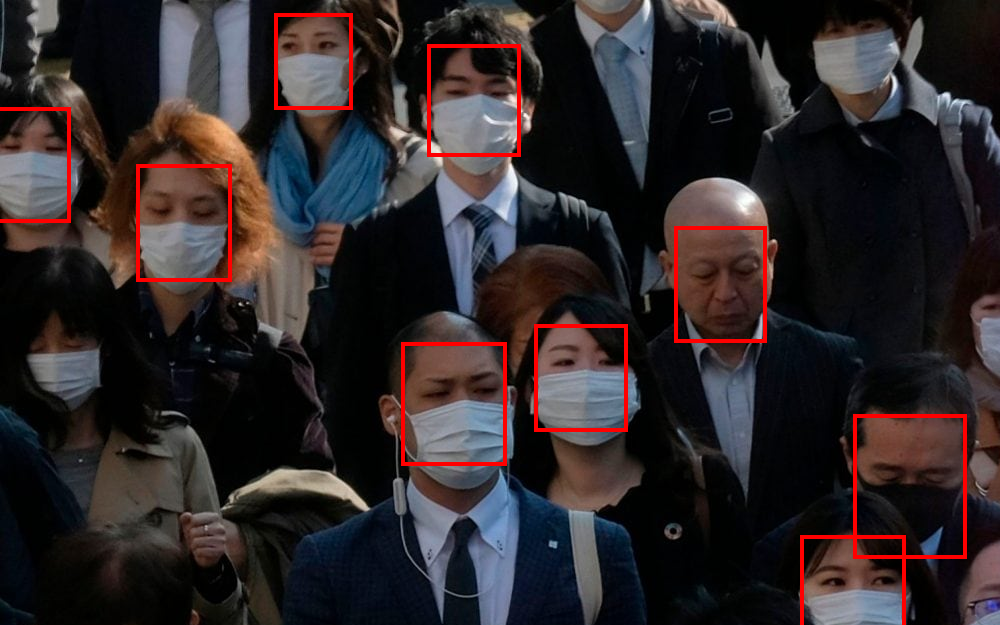

In [10]:
imd_draw

In [11]:
imd_draw, _,_ = face_detector.process_image(img, put_text=True)

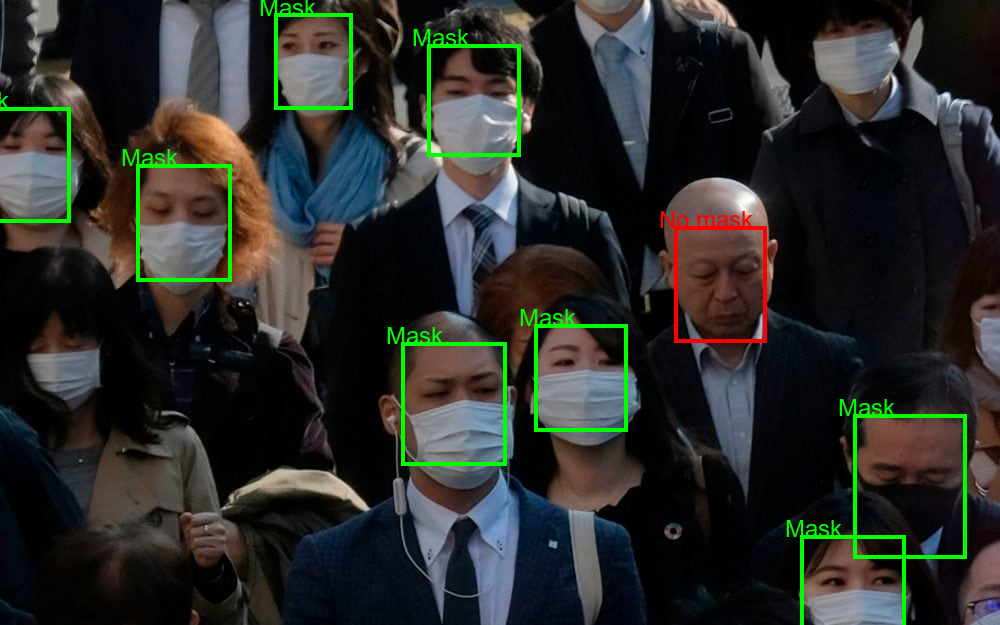

In [12]:
imd_draw

### Our detector

In [6]:
detector = FAN_detector.resnet34(num_classes=3)
detector.load_state_dict(torch.load('./weights/FAN.best.pth'))
detector.eval()
detector.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
face_detector = FaceDetector(classif, detector, detector_type='fan')

In [8]:
img = Image.open('./imgs/test_img.png')
imd_draw, faces,_ = face_detector.process_image(img, put_text=False)

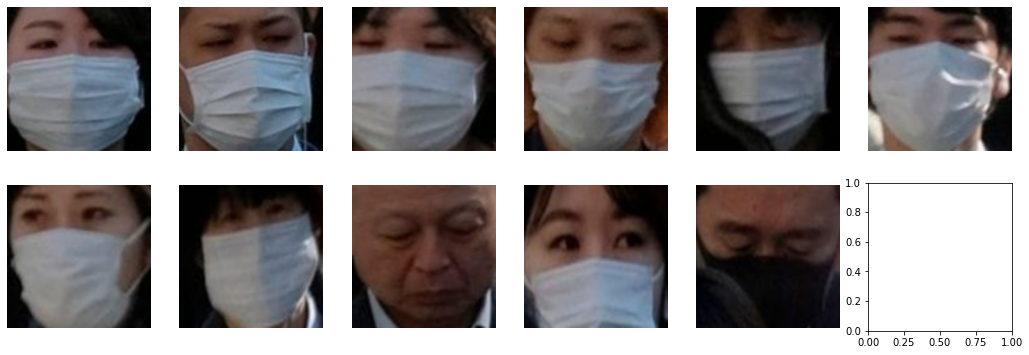

In [9]:
n_row = 2
n_col = len(faces)//2 + 1
_, axs = plt.subplots(n_row, n_col, figsize=(int(6*n_col/n_row), 6))
axs = axs.flatten()
for face, ax in zip(faces, axs):
    ax.imshow(TF.to_pil_image(face))
    ax.axis('off')
plt.show()

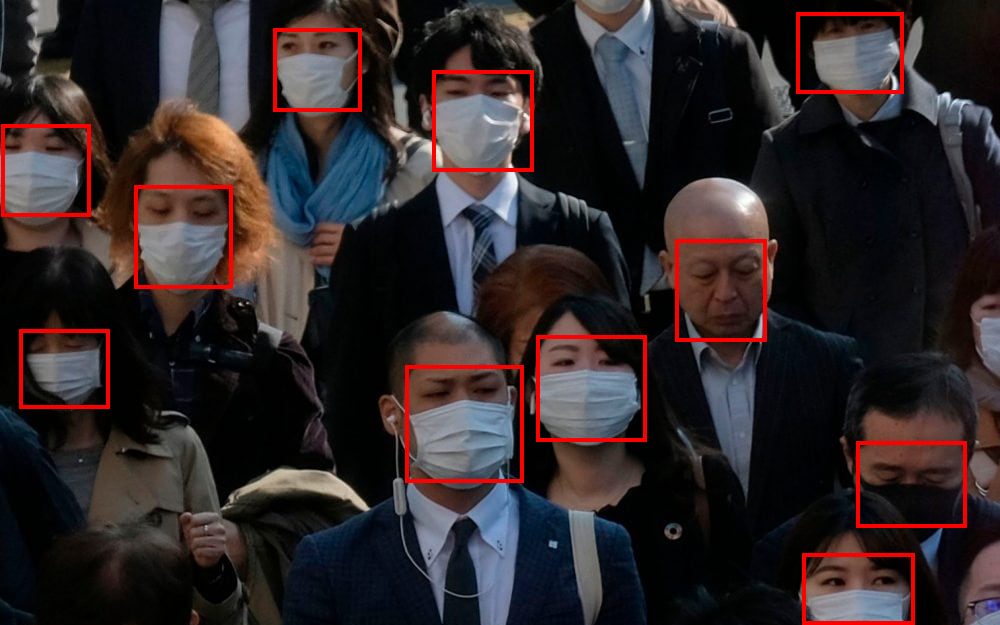

In [10]:
imd_draw

In [11]:
imd_draw, _,_ = face_detector.process_image(img, put_text=True)

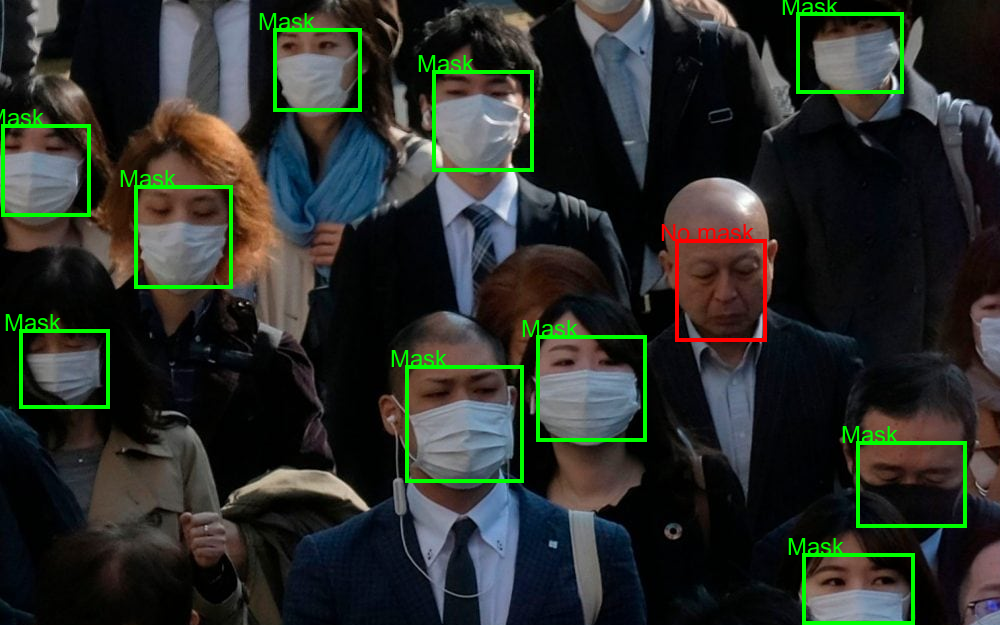

In [12]:
imd_draw

# VIdeos

### Our detector

In [20]:
detector = FAN_detector.resnet34(num_classes=3)
detector.load_state_dict(torch.load('./weights/FAN.best.pth'))
detector.eval()
detector.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [21]:
face_detector = FaceDetector(classif, detector, detector_type='fan')

In [22]:
video_frames, video_faces = face_detector.process_video('videos/', 'Эпизод 01.mp4')

Start video face tracking
Tracking frame: 38
Done


In [23]:
_ = face_detector.create_video(video_frames, path = './videos/', name = 'ep1_fan.mp4', framerate = 15)

In [24]:
display.Video('videos/ep1_fan.mp4', width=640)

In [25]:
video_frames, video_faces = face_detector.process_video('videos/', 'me.mp4')

Start video face tracking
Tracking frame: 688
Done


In [26]:
_ = face_detector.create_video(video_frames, path = './videos/', name = 'me_fan.mp4', framerate = 30)

In [27]:
display.Video('./videos/me_fan.mp4', width=640)

In [28]:
video_frames, video_faces = face_detector.process_video('./videos/', 'test1.mp4')

Start video face tracking
Tracking frame: 209
Done


In [29]:
_ = face_detector.create_video(video_frames, path = './videos/', name = 'out1_fan.mp4', framerate = 15)

In [30]:
display.Video('./videos/out1_fan.mp4', width=640)

In [31]:
video_frames, video_faces = face_detector.process_video('./videos/', 'test2.mp4')

Start video face tracking
Tracking frame: 612
Done


In [32]:
_ = face_detector.create_video(video_frames, path = './videos/', name = 'out2_fan.mp4', framerate = 15)

In [33]:
display.Video('./videos/out2_fan.mp4', width=640)

In [34]:
video_frames, video_faces = face_detector.process_video('./videos/', 'test3.mp4')

Start video face tracking
Tracking frame: 380
Done


In [35]:
_ = face_detector.create_video(video_frames, path = './videos/', name = 'out3_fan.mp4', framerate = 15)

In [36]:
display.Video('./videos/out3_fan.mp4', width=640)

## MTCNN

In [37]:
detector = MTCNN(keep_all=True, device=device)
face_detector = FaceDetector(classif, detector)

In [38]:
video_frames, video_faces = face_detector.process_video('./videos/', 'Эпизод 01.mp4')

Start video face tracking
Tracking frame: 38
Done


In [39]:
_ = face_detector.create_video(video_frames, path = './videos/', name = 'ep1_mtcnn.mp4', framerate = 15)

In [40]:
display.Video('./videos/ep1_mtcnn.mp4', width=640)

In [41]:
face_detector = FaceDetector(classif, detector)

In [42]:
video_frames, video_faces = face_detector.process_video('./videos/', 'me.mp4')

Start video face tracking
Tracking frame: 688
Done


In [43]:
_ = face_detector.create_video(video_frames, path = './videos/', name = 'me_mtcnn.mp4', framerate = 30)

In [44]:
display.Video('me_mtcnn.mp4', width=640)

In [45]:
video_frames, video_faces = face_detector.process_video('./videos/', 'test1.mp4')

Start video face tracking
Tracking frame: 209
Done


In [46]:
_ = face_detector.create_video(video_frames, path = './videos/', name = 'out1_mtcnn.mp4', framerate = 15)

In [47]:
display.Video('./videos/out1_mtcnn.mp4', width=640)

In [48]:
video_frames, video_faces = face_detector.process_video('./videos/', 'test2.mp4')

Start video face tracking
Tracking frame: 612
Done


In [49]:
_ = face_detector.create_video(video_frames, path = './videos/', name = 'out2_mtcnn.mp4', framerate = 15)

In [50]:
display.Video('./videos/out2_mtcnn.mp4', width=640)

In [51]:
video_frames, video_faces = face_detector.process_video('./videos/', 'test3.mp4')

Start video face tracking
Tracking frame: 380
Done


In [52]:
_ = face_detector.create_video(video_frames, path = './videos/', name = 'out3_mtcnn.mp4', framerate = 15)

In [53]:
display.Video('./videos/out3_mtcnn.mp4', width=640)